In [1]:
import pandas as pd
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
import matplotlib.pyplot as plt

/home/maybe/miniconda3/envs/task2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-16 16:42:23,697	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-16 16:42:23,769	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
DATA_PATH = "evs1_012_1_bar_harmonics_median_new.csv" # Путь до датасета
HORIZON = 100    # Горизонт прогноза 
INPUT_SIZE = 200 # Размер окна истории
EPOCHS = 60 # Количество эпох обучения
OUTPUT_DATA_PATH = "output.csv" # Путь до итогового набора данных

In [3]:
df = pd.read_csv(DATA_PATH, parse_dates=['date'])
df = df.rename(columns={'date': 'ds', 'value': 'y'})
df['unique_id'] = 'id_1'

In [4]:
model = TimesNet(
    h=HORIZON,
    input_size=INPUT_SIZE,
    max_steps=60,
    learning_rate=1e-3,
    scaler_type='standard'
)
nf = NeuralForecast(models=[model], freq='D')  
nf.fit(df=df)

Seed set to 1
/home/maybe/miniconda3/envs/task2/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | T

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=1, train_loss_step=0.442, train_loss_epoch=0.442]

`Trainer.fit` stopped: `max_steps=60` reached.


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=1, train_loss_step=0.442, train_loss_epoch=0.442]


In [5]:
forecast_df = nf.predict()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.41it/s]


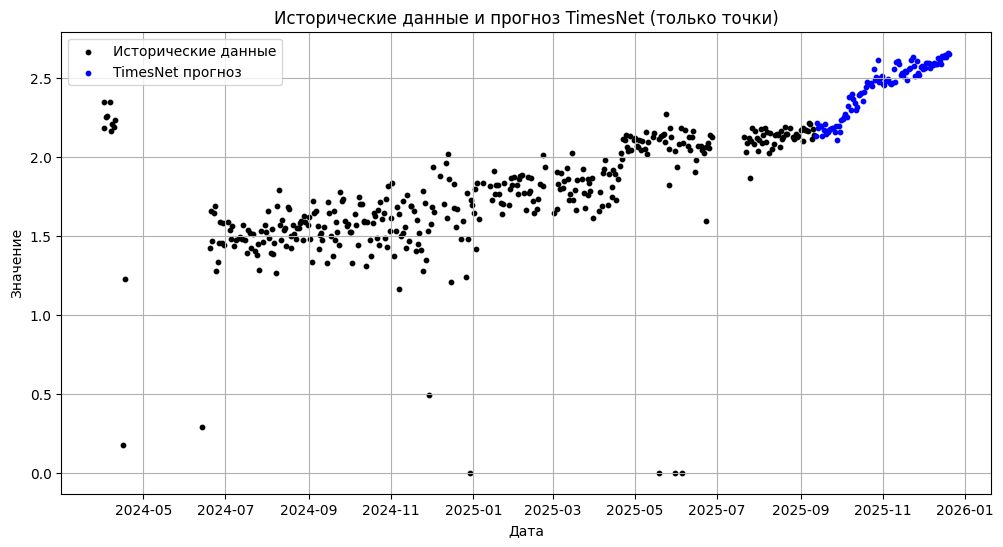

In [6]:
actual = df.set_index('ds')['y']
forecast = forecast_df.set_index('ds')['TimesNet']
plt.figure(figsize=(12, 6))
plt.scatter(actual.index, actual.values, color='black', label='Исторические данные', s=10)
plt.scatter(forecast.index, forecast.values, color='blue', label='TimesNet прогноз', s=10)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исторические данные и прогноз TimesNet (только точки)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
forecast_df_renamed = forecast_df.rename(columns={'TimesNet': 'y'})
df_tail = df.tail(INPUT_SIZE)[['ds', 'y']]
combined = pd.concat([df_tail, forecast_df_renamed[['ds', 'y']]], ignore_index=True)
combined.to_csv(OUTPUT_DATA_PATH, index=False)